In [1]:
import numpy as np
import pandas as pd
from scipy.interpolate import PchipInterpolator
import xarray as xr
import gsw

with open('../../woa18/path-to-woa18-files.txt') as f:
    path_woa = f.readline()

seasons = {}
for m in [1,2,3]: seasons[m] = '13'
for m in [4,5,6]: seasons[m] = '14'
for m in [7,8,9]: seasons[m] = '15'
for m in [10,11,12]: seasons[m] = '16'
    
depths = np.array([0,5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100,125,150,175,200,225,250,275,300,325,350,
       375,400,425,450,475,500,550,600,650,700,750,800,850,900,950,1000,1050,1100,1150,1200,1250,1300,1350,1400,
       1450,1500,1550,1600,1650,1700,1750,1800,1850,1900,1950,2000,2100,2200,2300,2400,2500,2600,2700,2800,2900,
       3000,3100,3200,3300,3400,3500,3600,3700,3800,3900,4000,4100,4200,4300,4400,4500,4600,4700,4800,4900,
       5000,5100,5200,5300,5400,5500])
    
def find_index(value, array):
    index = np.argmin(np.abs(value - array))
    return index

## CDisk4 bottle data
data is from https://www.bco-dmo.org/dataset-deployment/837374

In [2]:
# load CDisk4 CTD data
df = pd.read_csv("data/cdisk4_bottle_data.csv", skiprows=6, na_values=-9999)

df.columns

Index(['Station', 'CastNo', 'Latitude', 'Longitude', 'Bottle', 'Depth',
       'Pressure', 'Temp', 'Sal', 'O2', 'Density', 'Fluorescence', 'Theta',
       'Density_anomaly', 'Sigma0', 'Sigma4', 'Phosphate', 'Nitrate',
       'Silicate', 'AOU', 'Alk', 'DIC', 'd13C_DIC', 'pHTpTS', 'pHTp0T25S',
       'OmegaCa_Alk_DIC_PTS', 'OmegaCa_Alk_pH_corr_PTS',
       'OmegaCa_pH_corr_DIC_PTS', 'OmegaAr_Alk_DIC_PTS',
       'OmegaAr_Alk_pH_incorr_PTS', 'OmegaAr_pH_corr_DIC_PTS'],
      dtype='object')

# Make dataset for CANYON-B (with WOA data)
Columns needed:
- already exists, no changes
    - Latitude
    - Longitude
    - Depth
    - Pressure
- from WOA:
    - Temp
    - Salinity 
    - Doxy
    - extra: PO4, SiOH4
- Year, Month


In [3]:
def import_var_an(var, lat, lon, seas):
    # import annual (y) and seasonal (s) data
    try:
        if (var == 't') or (var == 's'):
            var_y = xr.open_dataset(path_woa+"woa18_decav_"+var+"00_01.nc", decode_times=False).isel(time=0, drop=True)
            var_s = xr.open_dataset(path_woa+"woa18_decav_"+var+seas+"_01.nc", decode_times=False).isel(time=0, drop=True)
        else:
            var_y = xr.open_dataset(path_woa+"woa18_all_"+var+"00_01.nc", decode_times=False).isel(time=0, drop=True)
            var_s = xr.open_dataset(path_woa+"woa18_all_"+var+seas+"_01.nc", decode_times=False).isel(time=0, drop=True)
    except:
        print(var, 'file is missing')

    # find location of measurement site:
    var_y_loc = var_y.isel(lat=find_index(lat, var_y.lat.values), lon=find_index(lon, var_y.lon.values)) 
    var_s_loc = var_s.isel(lat=find_index(lat, var_s.lat.values), lon=find_index(lon, var_s.lon.values)) 
    
    # get arrays (annual average (an), standard deviation (sd), number of observations (dd))
    # upper 800 (43 levels) from seasonal (if season not known, then it's just the annual data anyway)
    # everything below is from annual data
    if (var == 'p') or (var == 'i'):
        var_an = np.append(var_s_loc[var+'_an'].values[0:43], var_y_loc[var+'_an'].values[43:])
    else:
        var_an = np.append(var_s_loc[var+'_an'].values[0:57], var_y_loc[var+'_an'].values[57:])
    
    return var_an

def get_interpolators(var, lat, lon, seas, datatype='an'):        
    if datatype == 'sd':
        var_arr = import_var_sd(var, lat, lon, seas)
    else: 
        var_arr = import_var_an(var, lat, lon, seas)
    
    try:
        # can't interpolate if array has nan values, need to adjust what is used for interpolation
        try:
            if np.count_nonzero(np.isnan(var_arr)) > 0:
                var_interp = PchipInterpolator(depths[:-np.count_nonzero(np.isnan(var_arr))], 
                                       var_arr[:-np.count_nonzero(np.isnan(var_arr))], 
                                       extrapolate=False)        
            else:
                var_interp = PchipInterpolator(depths, var_arr, extrapolate=False)
        except:
            print('need to extrapolate')
            if np.count_nonzero(np.isnan(var_arr)) > 0:
                var_interp = PchipInterpolator(depths[:-np.count_nonzero(np.isnan(var_arr))], 
                                       var_arr[:-np.count_nonzero(np.isnan(var_arr))], 
                                       extrapolate=True)        
            else:
                var_interp = PchipInterpolator(depths, var_arr, extrapolate=True)
            
    except:
        print("can't interpolate")   
        
    return var_interp

In [4]:
# add time
df['Year'] = 2017
df['Month'] = 8


for lat, lon in zip(df["Latitude"].unique(), df["Longitude"].unique()):
    locat = (df["Latitude"] == lat) & (df["Longitude"] == lon)
        
    for month in df[locat]['Month'].unique():
        # no month given, annual average instead of a season
        if np.isnan(month):
            seas = '00'
        else:
            seas = seasons[month] 
        
        # to avoid having gridcell that is empty becasuse station was too close to shore (Station 7)
        if df[locat]['Depth'].max() > 500:
            t_interp = get_interpolators('t', lat, lon, seas)
            df.loc[(locat),["Temp_WOA"]] = t_interp(df[locat]['Depth'])

            s_interp = get_interpolators('s', lat, lon, seas)                
            df.loc[(locat),["Salinity_WOA"]] = s_interp(df[locat]['Depth'])        

            o_interp = get_interpolators('o', lat, lon, seas)                
            df.loc[(locat),["Doxy_WOA"]] = o_interp(df[locat]['Depth'])

            p_interp = get_interpolators('p', lat, lon, seas)                
            df.loc[(locat),["PO4_WOA"]] = p_interp(df[locat]['Depth'])

            i_interp = get_interpolators('i', lat, lon, seas)                
            df.loc[(locat),["SiOH4_WOA"]] = i_interp(df[locat]['Depth'])
        

# save dataset (only up to (and including) Station 5)
df = df[df['Station'] < 6]
df.to_csv("data/cdisk4_withWOA.csv", index=False)

## Comparison Figure S11

In [5]:
import matplotlib.pyplot as plt
import string

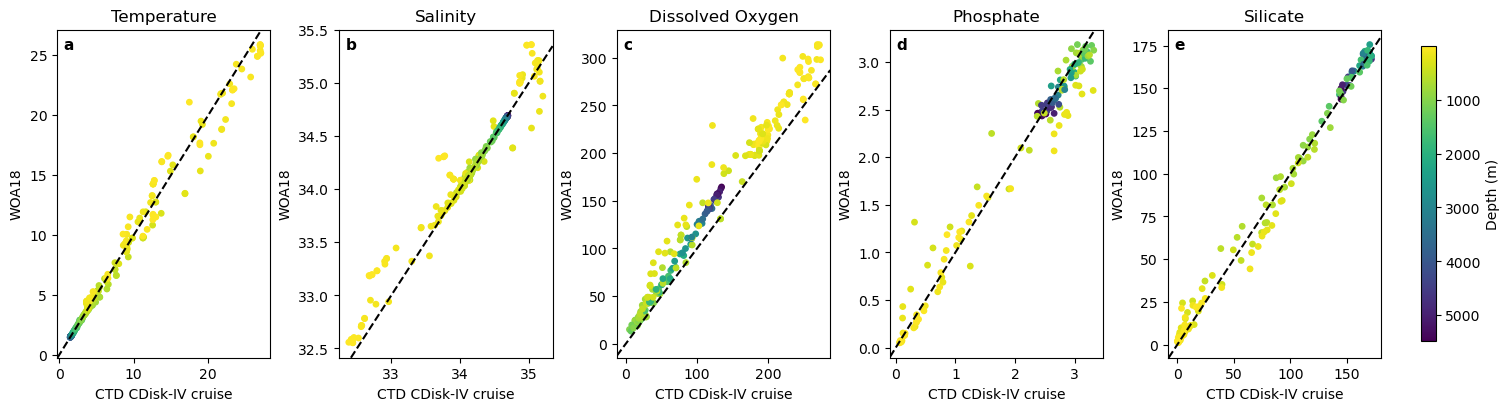

In [6]:
fig, axs = plt.subplots(nrows=1,ncols=5, figsize=(15,4), layout='compressed')

for a in axs:
    a.set_ylabel('WOA18')
    a.set_xlabel('CTD CDisk-IV cruise')
    
cb = axs[0].scatter(df['Temp'], df['Temp_WOA'], c=df['Depth'], cmap='viridis_r', s=15)
axs[0].axline((1,1), slope=1, color='black', linestyle='--')
axs[0].set_title('Temperature')

axs[1].scatter(df['Sal'], df['Salinity_WOA'], c=df['Depth'], cmap='viridis_r', s=15)
axs[1].axline((35,35), slope=1, color='black', linestyle='--')
axs[1].set_title('Salinity')

axs[2].scatter(df['O2'], df['Doxy_WOA'], c=df['Depth'], cmap='viridis_r', s=15)
axs[2].axline((1,1), slope=1, color='black', linestyle='--')
axs[2].set_title('Dissolved Oxygen')

axs[3].scatter(df['Phosphate'], df['PO4_WOA'], c=df['Depth'], cmap='viridis_r', s=15)
axs[3].axline((1,1), slope=1, color='black', linestyle='--')
axs[3].set_title('Phosphate')

axs[4].scatter(df['Silicate'], df['SiOH4_WOA'], c=df['Depth'], cmap='viridis_r', s=15)
axs[4].axline((1,1), slope=1, color='black', linestyle='--')
axs[4].set_title('Silicate')

#plt.suptitle('WOA vs CDisk4 cruise measurements', fontsize=14)


cbar = fig.colorbar(cb, ax=axs, label='Depth (m)', shrink=0.9, pad=0.03) 
cbar.ax.invert_yaxis()

for n,ax in enumerate(axs.flatten()):
    ax.annotate(string.ascii_lowercase[n], (0.03, 0.94), xycoords='axes fraction', weight='bold', fontsize=11)

#plt.tight_layout()
plt.show()